In [2]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import *
import pandas as pd
import requests
import os

In [3]:
# Create a spark session
spark = (
    SparkSession.builder.appName("Data Modelling 2")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.driver.memory", "9g") 
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config("spark.network.timeout", "600s")
    .getOrCreate()
)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/10/01 01:39:07 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## Read dataset

In [4]:
# Information on consumers
consumer_is_fraud = spark.read.parquet("../data/curated/all_details")

In [5]:
consumer_is_fraud.head()


Row(order_id='360a891b-8271-4611-8fc6-daac029a5214', user_id=44, merchant_abn=80788167198, order_datetime=datetime.date(2021, 8, 20), dollar_value=158.88701712957197, postcode='5074', merchant_fraud=0.0, consumer_fraud=0.0, weekly_personal_disposable=497.2312731843797, median_total_household_income=1427.0, median_total_family_income=1892.0, is_po_box=False, avg_household_size=2.4, sa2_name='Paradise - Newton', median_age=40.0, sa2_code='401041015')

In [6]:
all_features = ["order_id", "user_id", "merchant_abn", "order_datetime", 
                "dollar_value", "postcode", "merchant_fraud", "consumer_fraud", 
                "weekly_personal_disposable", "median_total_household_income", 
                "median_total_family_income", "is_po_box", 
                "avg_household_size", "sa2_name", "median_age", "sa2_code"]

In [7]:

from pyspark.sql.functions import monotonically_increasing_id

In [8]:
consumer_is_fraud.count()

14195505

In [9]:
consumer_is_fraud.filter(F.col('consumer_fraud') > 0).count()

80348

In [10]:
positive_consumer_is_fraud = consumer_is_fraud.filter(F.col('consumer_fraud') > 0)

## Feature selection

In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

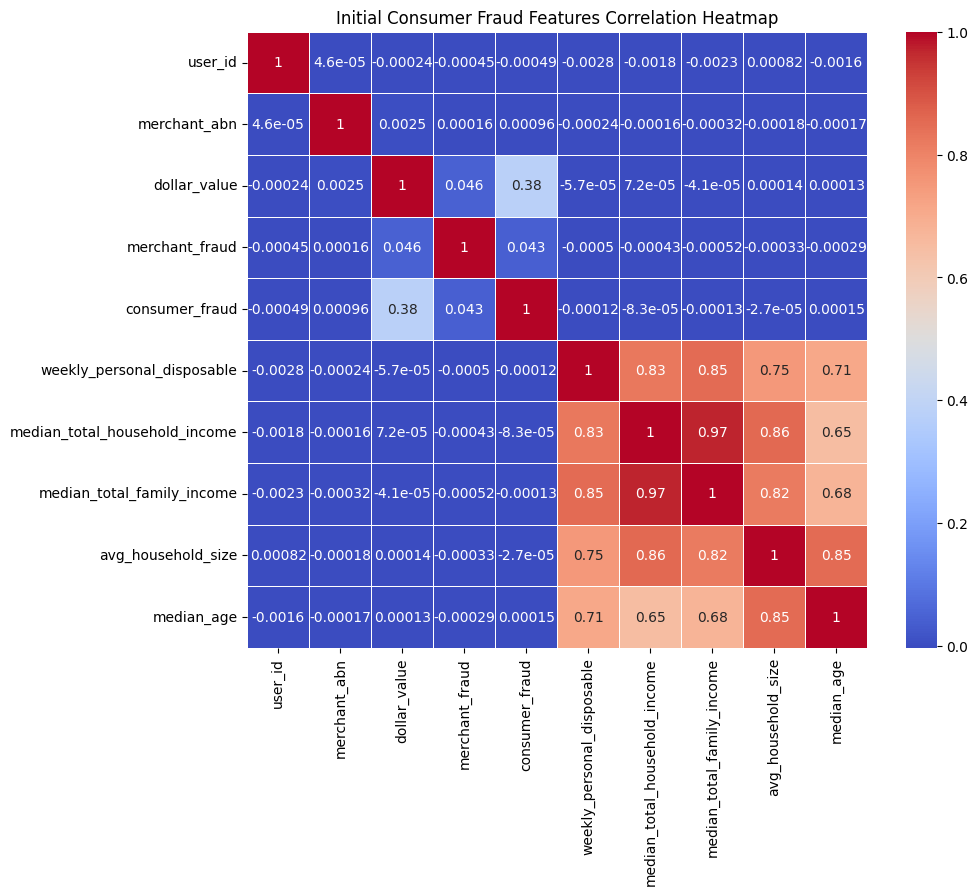

In [15]:
# Correlation analysis

# Check numerical cols
numerical_columns = ['user_id', 'merchant_abn', 'dollar_value', 'merchant_fraud', 'consumer_fraud', 
                     'weekly_personal_disposable', 'median_total_household_income', 
                     'median_total_family_income', 'avg_household_size', 'median_age']

# Calculate the correlation matrix for the numerical columns
correlations = {}
for col1 in numerical_columns:
    correlations[col1] = []
    for col2 in numerical_columns:
        corr_value = consumer_is_fraud.corr(col1, col2)
        correlations[col1].append(corr_value)

# Convert the correlation dictionary to a Pandas DataFrame for visualization
corr_df = pd.DataFrame(correlations, index=numerical_columns)

# Plot the heatmap using Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(corr_df, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Initial Consumer Fraud Features Correlation Heatmap')
plt.savefig("../plots/Initial Consumer Fraud Features Correlation Heatmap.png")
plt.show()

Since the consumer fraud field is 0-inflated, the numerical features have little correlation.

Analyze non-zero part's correlation is more meaningful.

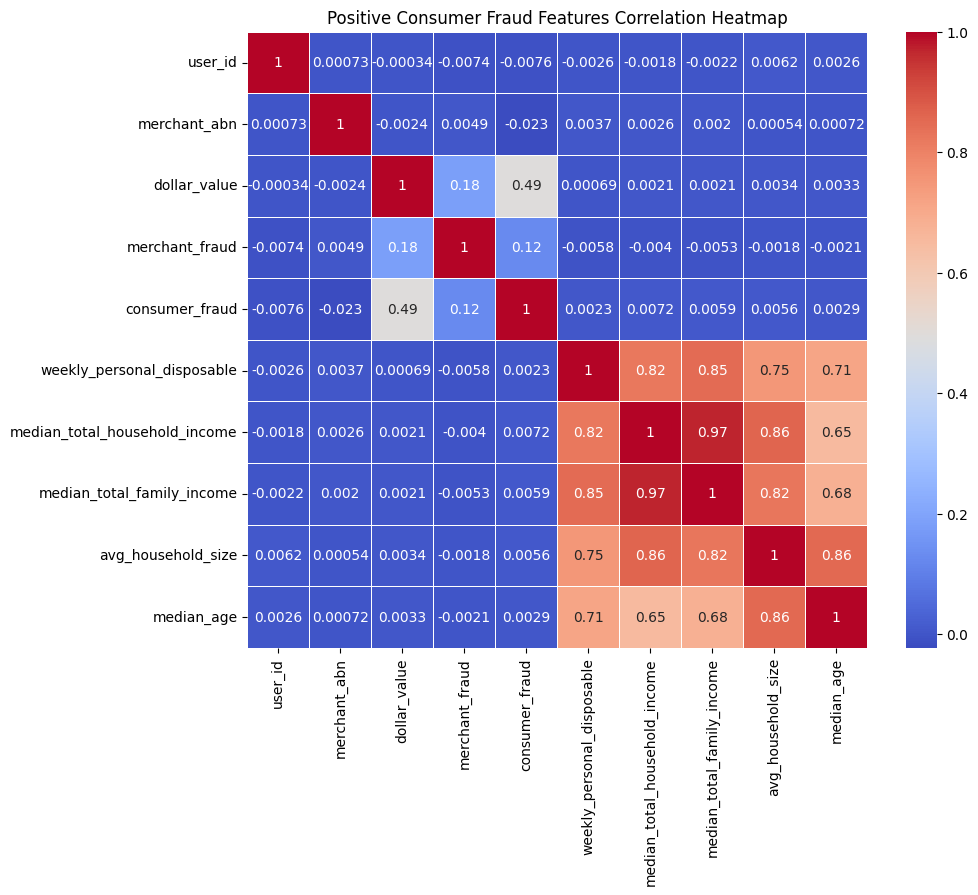

In [16]:
# Correlation analysis

# Check numrical cols
numerical_columns = ['user_id', 'merchant_abn', 'dollar_value', 'merchant_fraud', 'consumer_fraud', 
                     'weekly_personal_disposable', 'median_total_household_income', 
                     'median_total_family_income', 'avg_household_size', 'median_age']

# Calculate the correlation matrix for the numerical columns
correlations = {}
for col1 in numerical_columns:
    correlations[col1] = []
    for col2 in numerical_columns:
        corr_value = positive_consumer_is_fraud.corr(col1, col2) # non-zero consumer fraud
        correlations[col1].append(corr_value)

# Convert the correlation dictionary to a Pandas DataFrame for visualization
corr_df = pd.DataFrame(correlations, index=numerical_columns)

# Plot the heatmap using Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(corr_df, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Positive Consumer Fraud Features Correlation Heatmap')
plt.savefig("../plots/Positive Consumer Fraud Features Correlation Heatmap.png")
plt.show()

'weekly_personal_disposable', 'median_total_household_income', 'median_total_family_income', 'avg_household_size' are highly correlated. Keep 'median_total_household_income' only
Although merchant fraud displays relatively higher correlation with consumer fraud, to avoid dependency between features of the final model, removing it from the input features.

In [17]:

# select the useful features

useful_num_features = ['order_id', 'user_id', 'dollar_value', 'median_total_household_income', 'median_age']
target_feature = ['consumer_fraud']
selected_features = useful_num_features + target_feature

We want to check the correlation between each attribute using a subsample dataset. The subsample dataset contains 30% of the 2022 data and 70% of the 2021 data as we will train model on the data in 2021 and test it on the data in 2022.

Because pyspark ml can't handle Null values, we drop external attributes that contain Null values.

In [18]:
impute_consumer_fraud_sdf = consumer_is_fraud.select(selected_features)
impute_consumer_fraud_sdf.limit(5)

order_id,user_id,dollar_value,median_total_household_income,median_age,consumer_fraud
360a891b-8271-461...,44,158.88701712957197,1427.0,40.0,0.0
5c77cc43-b0fd-432...,44,14.31708123947184,1427.0,40.0,0.0
e75d90e3-2656-4dc...,44,56.782923459184794,1427.0,40.0,0.0
a9f754e4-af51-463...,44,26.557524640642136,1427.0,40.0,0.0
71753d60-5634-422...,44,139.3475757940659,1427.0,40.0,0.0


In [19]:
impute_consumer_fraud_sdf.count()

14195505

In [20]:
impute_consumer_fraud_sdf.filter(F.col("median_total_household_income").isNotNull()).count()

11715485

As we expected, there are some consumer not existing in transaction dataset, we will remove those instances.

In [21]:


impute_consumer_fraud_sdf = impute_consumer_fraud_sdf.filter(F.col("median_total_household_income").isNotNull())

Let's check the number of instances with non-missing fraud probability.

In [22]:
impute_consumer_fraud_sdf.filter(F.col('consumer_fraud') > 0).count()

66236

We would like to use these instances to build a imputation model for the remaining null values.

In [23]:
model_df = impute_consumer_fraud_sdf.filter(F.col('consumer_fraud') > 0)

In [24]:
final_df = model_df.dropna('any')
final_df.count()

66236

In [25]:
final_df.limit(5)

order_id,user_id,dollar_value,median_total_household_income,median_age,consumer_fraud
c5122a04-c632-44a...,61,337.3779725774622,1385.0,44.0,8.644157347203842
13a25701-db06-48f...,61,1674.695742413631,1385.0,44.0,8.644157347203842
bfb799c4-a207-444...,61,2785.5146602145714,1385.0,44.0,11.966970611682775
277d2bd9-b8bb-4f0...,105,5496.481486904571,1564.0,33.0,9.95491210863442
9ab0bced-f5fe-4d0...,105,90.26474368141248,1564.0,33.0,9.95491210863442


In [26]:
# Save data to file
final_df.write.mode('overwrite').parquet('../data/curated/modelling_consumer_fraud/')

In [27]:
model_sdf = spark.read.parquet('../data/curated/modelling_consumer_fraud')

## Train Random Forest regression

In [28]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator

In [29]:
# Split the data into training and test sets (30% held out for testing)
(trainingData, testData) = model_sdf.randomSplit([0.8, 0.2], seed=42)

In [30]:
print(trainingData.count())
print(testData.count())

53144
13092


### Baseline Model

The model only predicts the mean value for all test instances.

In [31]:
mean_value = testData.agg(F.mean("consumer_fraud")).collect()[0][0]
mean_predictions_df = testData.select("consumer_fraud").withColumn("prediction", F.lit(mean_value))

mse_evaluator = RegressionEvaluator(labelCol="consumer_fraud", predictionCol="prediction", metricName="mse")
mae_evaluator = RegressionEvaluator(labelCol="consumer_fraud", predictionCol="prediction", metricName="mae")

# Get the score
mse = mse_evaluator.evaluate(mean_predictions_df)
mae = mae_evaluator.evaluate(mean_predictions_df)

print(f"Mean Square Error: {mse}")
print(f"Mean Absolute Error: {mae}")

Mean Square Error: 84.01282008988863
Mean Absolute Error: 5.751040341617527


### Random Forest

We aim to create a simple model, therefore, the model hyperparameters were chosen arbitrarily.

In [32]:
from pyspark.ml import Pipeline

In [33]:
features = 'features'
input_cols = trainingData.drop('consumer_fraud').drop('order_id').drop('user_id').columns

assembler = VectorAssembler(
    # which column to combine
    inputCols=input_cols, 
    # How should the combined columns be named
    outputCol=features
)

In [34]:
rft = RandomForestRegressor(
    featuresCol='features', 
    labelCol='consumer_fraud',
    numTrees=5, 
    maxDepth=5,
    seed=42
)

In [35]:
pipeline = Pipeline(stages=[assembler, rft])
model = pipeline.fit(trainingData)

- Make predictions.

In [38]:
predictions = model.transform(testData)

In [39]:
predictions.head(5)

[Row(order_id='00020f61-26ba-4db9-99d3-432081e3af09', user_id=17313, dollar_value=38.4756282948044, median_total_household_income=1300.0, median_age=49.0, consumer_fraud=10.886889604461858, features=DenseVector([38.4756, 1300.0, 49.0]), prediction=13.711731912333573),
 Row(order_id='000dc0bd-075b-49ac-bc24-cbe2c1ec255c', user_id=15572, dollar_value=490.3672642283532, median_total_household_income=1154.0, median_age=51.0, consumer_fraud=9.65651990738012, features=DenseVector([490.3673, 1154.0, 51.0]), prediction=12.878381647120355),
 Row(order_id='000f0f12-7a95-4b47-84b0-63bf67c723ac', user_id=17200, dollar_value=2960.305729357243, median_total_household_income=1321.0, median_age=50.0, consumer_fraud=15.611674823201511, features=DenseVector([2960.3057, 1321.0, 50.0]), prediction=12.88032835776949),
 Row(order_id='0024b672-f9f4-4913-90c4-eda805da3ff6', user_id=21214, dollar_value=126.2497882122412, median_total_household_income=1172.0, median_age=31.0, consumer_fraud=9.161455922353444, f

- Evaluate the predictions.

In [51]:
mse_evaluator = RegressionEvaluator(labelCol="consumer_fraud", predictionCol="prediction", metricName="mse")
mae_evaluator = RegressionEvaluator(labelCol="consumer_fraud", predictionCol="prediction", metricName="mae")

# Get the score
mse = mse_evaluator.evaluate(predictions)
mae = mae_evaluator.evaluate(predictions)

print(f"Mean Square Error: {mse}")
print(f"Mean Absolute Error: {mae}")


Mean Square Error: 62.079918721739816
Mean Absolute Error: 4.9027066599159586


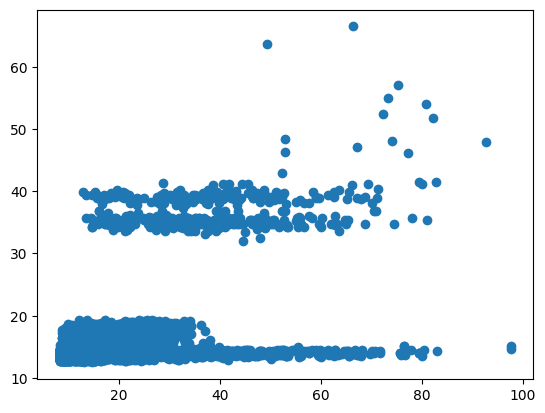

In [52]:
result_pd = predictions.select("prediction", "consumer_fraud").toPandas()
plt.scatter(result_pd.consumer_fraud, result_pd.prediction)

### Imputation for consumer fraud probability

In [53]:
imputation_data = impute_consumer_fraud_sdf.filter(F.col('consumer_fraud') == 0).drop('consumer_fraud')

In [54]:
imputed_sdf = model.transform(imputation_data)

In [55]:
imputed_sdf.select("prediction").describe()

summary,prediction
count,11649249
mean,14.001130561031971
stddev,0.500908134637919
min,12.483153558798758
max,66.7436362755338


We merge imputed consumer fraud probability to the main dataset.

In [56]:
# data with given consumer fraud probability
non_missing_consumer_fraud = model_sdf.select(["order_id", "consumer_fraud"])
imputed_sdf_select = imputed_sdf.select(["order_id", "prediction"]).withColumnRenamed("prediction", "consumer_fraud")

# Combine two dataset
full_consumer_fraud = imputed_sdf_select.union(non_missing_consumer_fraud)

In [57]:
# Save data to file
full_consumer_fraud.write.mode('overwrite').parquet('../data/curated/predicted_consumer_fraud/')

In [58]:
full_consumer_fraud.count()

11715485

In [59]:
test = spark.read.parquet('../data/curated/predicted_consumer_fraud/')
test.count()

11715485